In [ ]:
!git clone https://github.com/zzeiidann/FNN.git

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import sys
import os
import re

from tqdm import tqdm

In [3]:
sys.path.append('./FNN')
from FNN_1 import FNN, CachedBERTDataset
from FNN_1_GPU import FNNGPU

2025-04-13 10:58:55.629699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744541935.873946      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744541935.941733      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1744541957.017285      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# **Assign Data**

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/zzeiidann/Data/refs/heads/main/filtered_reviews_1_2_5.csv')
data

,overall,reviewText
0,5.0,It's good for beginners
1,5.0,I recommend this starter Ukulele kit. I has e...
2,5.0,G'daughter received this for Christmas present...
3,1.0,Please pay attention better than I did to the ...
4,5.0,"thanx, b"
...,...,...
176574,5.0,ok
176575,5.0,It's pretty great.
176576,5.0,Good inexpensive wiring harness. It will do th...
176577,1.0,The description stated they were full size pot...


In [7]:
data['overall'] = data['overall'].apply(lambda x: 0 if x < 5 else 1)
data.rename(columns={'overall': 'sentiment'}, inplace=True)
data

,sentiment,reviewText
0,1,It's good for beginners
1,1,I recommend this starter Ukulele kit. I has e...
2,1,G'daughter received this for Christmas present...
3,0,Please pay attention better than I did to the ...
4,1,"thanx, b"
...,...,...
176574,1,ok
176575,1,It's pretty great.
176576,1,Good inexpensive wiring harness. It will do th...
176577,0,The description stated they were full size pot...


In [8]:
data['reviewText'] = data['reviewText'].astype(str)
data['sentiment'] = data['sentiment'].astype(int)

Sentiment Distribution:
sentiment
1    161837
0     14742
Name: count, dtype: int64


/var/folders/m3/3gmfjhln13qbt6p_47473gs40000gn/T/ipykernel_1683/1922752580.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='Set1', linewidth=0.5, edgecolor='black')


Text(0.5, 1.0, 'Sentiment Distribution')

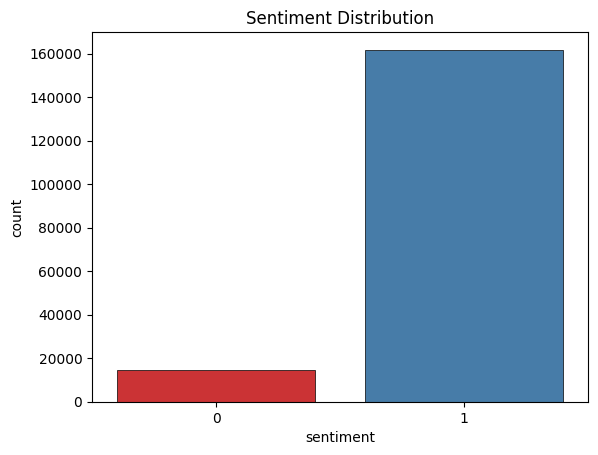

In [22]:
print('Sentiment Distribution:')
print(data['sentiment'].value_counts())
sns.countplot(x='sentiment', data=data, palette='Set1', linewidth=0.5, edgecolor='black')
plt.title('Sentiment Distribution')

# **Preprocessing**

In [8]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = remove_emojis(text)
    text = re.sub(r'[^\w\s,.!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_data = [clean_text(contents) for contents in tqdm(data['reviewText'], desc="Cleaning Text")]
data['reviewText'] = cleaned_data

Cleaning Text: 100%|██████████| 176579/176579 [00:06<00:00, 28674.27it/s]


In [9]:
data = pd.concat([
    data[data['sentiment'] != 1].sample(n=7000, random_state=42),
    data[data['sentiment'] == 1].sample(n=7000, random_state=42)
]).reset_index(drop=True)

In [10]:
print('Sentiment Distribution:')
print(data['sentiment'].value_counts())

Sentiment Distribution:
sentiment
0    7000
1    7000
Name: count, dtype: int64


# **Training Model**

In [11]:
texts = data['reviewText']
labels = data['sentiment']

In [12]:
dataset = CachedBERTDataset(texts, labels, bert_model='joeddav/xlm-roberta-large-xnli')

Loading BERT model: joeddav/xlm-roberta-large-xnli


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [13]:
model = FNNGPU(dims=[1024, 500, 500, 2000, 64], n_clusters=4)

In [ ]:
import time
from keras.optimizers import SGD

start_time = time.time()

model.pretrain_autoencoder(dataset, batch_size=128, epochs=200)
model.load_weights('pretrained_ae.weights.pth')

end_time = time.time()
print(f"Total waktu: {end_time - start_time:.2f} detik")

Pretraining autoencoder...
Created tensor dataset with shape: torch.Size([14000, 1024])


Epoch 200/200: 100%|██████████| 110/110 [00:00<00:00, 240.12it/s, loss=0.008] 
/kaggle/working/./FNN/FNN_1_GPU/model.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ch

Saved weights to pretrained_ae.weights.pth
Autoencoder pretrained and weights saved to pretrained_ae.weights.pth
Loaded weights from pretrained_ae.weights.pth
Total waktu: 431.08 detik


In [15]:
model.clustering_with_sentiment(dataset, update_interval=40, maxiter=400)

Update interval 40
Created dataset with 14000 samples, embedding shape: torch.Size([14000, 1024]), label shape: torch.Size([14000])


Extracting features: 100%|██████████| 110/110 [00:00<00:00, 695.99it/s]

Class distribution: {0.0: 7000, 1.0: 7000}
Computed class weights: {0.0: 1.0, 1.0: 1.0}
Initializing cluster centers with k-means.


Save interval 275


Updating distribution (iter 0): 100%|██████████| 55/55 [00:00<00:00, 185.60it/s]


Class negative accuracy: 0.566
Class positive accuracy: 0.463
Iter 0: Cluster Loss 0.00000, Sentiment Loss 0.00000, Acc_sentiment 0.51450; loss=0.00000


Updating distribution (iter 40): 100%|██████████| 55/55 [00:00<00:00, 572.57it/s]


Class negative accuracy: 0.92071
Class positive accuracy: 0.89943
Iter 40: Cluster Loss 4.79387, Sentiment Loss 25.87484, Acc_sentiment 0.91007; loss=26.35423


Updating distribution (iter 80): 100%|██████████| 55/55 [00:00<00:00, 589.22it/s]


Class negative accuracy: 0.92243
Class positive accuracy: 0.93114
Iter 80: Cluster Loss 3.53446, Sentiment Loss 22.40275, Acc_sentiment 0.92679; loss=22.75619


Updating distribution (iter 120): 100%|██████████| 55/55 [00:00<00:00, 559.57it/s]


Class negative accuracy: 0.95686
Class positive accuracy: 0.92529
Iter 120: Cluster Loss 4.60657, Sentiment Loss 21.44622, Acc_sentiment 0.94107; loss=21.90688


Updating distribution (iter 160): 100%|██████████| 55/55 [00:00<00:00, 569.93it/s]


Class negative accuracy: 0.96457
Class positive accuracy: 0.94714
Iter 160: Cluster Loss 5.49388, Sentiment Loss 20.72828, Acc_sentiment 0.95586; loss=21.27767


Updating distribution (iter 200): 100%|██████████| 55/55 [00:00<00:00, 572.89it/s]


Class negative accuracy: 0.97386
Class positive accuracy: 0.95757
Iter 200: Cluster Loss 6.12834, Sentiment Loss 20.09238, Acc_sentiment 0.96571; loss=20.70521


Updating distribution (iter 240): 100%|██████████| 55/55 [00:00<00:00, 583.68it/s]


Class negative accuracy: 0.97443
Class positive accuracy: 0.969
Iter 240: Cluster Loss 6.64111, Sentiment Loss 19.57650, Acc_sentiment 0.97171; loss=20.24061


Saved weights to ./results/fnnjst/FNN_model_275.weights.pth


Updating distribution (iter 280): 100%|██████████| 55/55 [00:00<00:00, 534.41it/s]


Class negative accuracy: 0.981
Class positive accuracy: 0.97071
Iter 280: Cluster Loss 7.00462, Sentiment Loss 19.18126, Acc_sentiment 0.97586; loss=19.88172


Updating distribution (iter 320): 100%|██████████| 55/55 [00:00<00:00, 593.88it/s]


Class negative accuracy: 0.97786
Class positive accuracy: 0.97971
Iter 320: Cluster Loss 7.21943, Sentiment Loss 18.83546, Acc_sentiment 0.97879; loss=19.55741


Updating distribution (iter 360): 100%|██████████| 55/55 [00:00<00:00, 591.24it/s]


Class negative accuracy: 0.98314
Class positive accuracy: 0.973
Iter 360: Cluster Loss 7.36048, Sentiment Loss 18.60725, Acc_sentiment 0.97807; loss=19.34330


Saved weights to ./results/fnnjst/FNN_model_final.weights.pth


(array([2, 0, 3, ..., 1, 2, 0]),
 array([[9.9916101e-01, 8.3900522e-04],
        [9.9955183e-01, 4.4818551e-04],
        [9.9999964e-01, 3.3928558e-07],
        ...,
        [9.2852752e-06, 9.9999070e-01],
        [1.6038600e-06, 9.9999845e-01],
        [1.0935213e-05, 9.9998903e-01]], dtype=float32))

# **Evaluation**

In [38]:
print(model.predict('The tools is exactly great', bert_model='joeddav/xlm-roberta-large-xnli'))
print(model.predict('Terrible store, bad packaging', bert_model='joeddav/xlm-roberta-large-xnli'))

[{'sentiment': 'positive', 'cluster': 0}]
[{'sentiment': 'negative', 'cluster': 0}]


In [19]:
embeddings = []
        
for i in range(len(dataset)):
    item = dataset[i]
    if isinstance(item, tuple): 
        embedding, _ = item
        embeddings.append(embedding.cpu().numpy())
    else:  # If dataset returns only embedding
        embeddings.append(item.cpu().numpy())

In [20]:
import numpy as np
x = np.array(embeddings)
x

array([[ 0.9195785 , -0.8768988 ,  0.11280026, ...,  0.11157522,
        -0.6903052 , -1.4258761 ],
       [-0.22469954,  0.09301493, -0.82869095, ...,  1.3723058 ,
        -0.59713703,  0.0221242 ],
       [ 0.56409436, -0.31838894,  0.3013509 , ..., -0.04831642,
         0.11705834, -1.5896189 ],
       ...,
       [ 1.2780327 , -0.39942145,  0.61917466, ...,  0.36787155,
        -0.8873446 , -1.2546521 ],
       [ 1.0899874 , -0.7105959 ,  0.10891363, ...,  0.04700159,
        -0.9589943 , -1.2996361 ],
       [-0.03455612,  0.52326757, -0.7238206 , ...,  1.1508124 ,
        -1.1021721 , -0.28440857]], dtype=float32)

In [34]:
model.set_stop_words(
    [
        # Standard English stopwords (subset dari nltk)
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
        "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
        'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
        'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
        'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
        'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
        'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having',
        'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
        'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
        'with', 'about', 'against', 'between', 'into', 'through', 'during',
        'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
        'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
        'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
        'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
        'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
        'than', 'too', 'very', 'can', 'will', 'just', 'don', "don't",
        'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
        'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
        'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
        "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
        "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won',
        "won't", 'wouldn', "wouldn't", 'one', 'ive', 'much', 'it.', 'well', 'better', 'guitar', 'sound'

        # Slang, typo, modern abbreviations
        'omg', 'lol', 'lmao', 'rofl', 'idk', 'idc', 'ikr', 'btw', 'tbh',
        'imo', 'imho', 'bruh', 'bro', 'sis', 'yo', 'ngl', 'smh', 'fyi',
        'atm', 'irl', 'afk', 'asap', 'bff', 'bffs', 'bday', 'tho', 'tho.',
        'cuz', 'coz', 'ya', 'yay', 'yup', 'nah', 'nope', 'yea', 'ok', 'okay',
        'plz', 'pls', 'uh', 'uhh', 'uhm', 'umm', 'hmm', 'haha', 'hehe',
        'huhu', 'aww', 'ugh', 'oof', 'wtf', 'wth', 'rip', 'xd', ':)', ':(',

        # App review specific
        'app', 'apps', 'application', 'apk', 'play', 'store', 'google',
        'account', 'login', 'sign', 'signup', 'signin', 'register',
        'install', 'uninstall', 'installed', 'uninstalled', 'device',
        'android', 'ios', 'phone', 'mobile', 'tablet', 'version',
        'update', 'crash', 'bug', 'fix', 'error', 'issue', 'problem',
        'slow', 'fast', 'lag', 'laggy', 'loading', 'load', 'performance',
        'feature', 'features', 'option', 'options', 'setting', 'settings',
        'ads', 'ad', 'advertisement', 'popup', 'banner', 'review',
        'rating', 'stars', 'dev', 'developer', 'team', 'support', 'help',
        'please', 'kindly', 'hope', 'wish', 'thanks', 'thank', 'love',
        'hate', 'like', 'dislike', 'amazing', 'awesome', 'great', 'good',
        'bad', 'worst', 'cool', 'nice', 'perfect', 'trash', 'useless',
        'sucks', 'wow', 'working', 'works', 'doesn’t', 'doesnt', 'won’t',
        'wont', 'can’t', 'cant', 'don’t', 'dont', 'would', 'could',
        'should',

        # Filler / stop words informal tambahan
        'literally', 'actually', 'basically', 'seriously', 'really',
        'totally', 'kinda', 'sorta', 'maybe', 'probably', 'definitely',
        'honestly', 'fr', 'legit', 'even', 'ever', 'always', 'never',
        'again', 'still', 'yet', 'already', 'also', 'tho', 'alr', 'let', 'bought', 'buy',
        'make', 'get', 'got', 'see', 'say', 'said', 'think', 'feel',
        'want', 'need', 'give', 'take', 'try', 'trying', 'keep', 'go', 'sounds',
        'went', 'back', 'come', 'came', 'sound', 'use', 'used', 'little', 'better', 'strings'
    ]
)

   
cluster = model.analyze_clusters(x, texts)


============== CLUSTER ANALYSIS ==============
   Cluster                                       Common Words  Text Count
0        0  product (219), quality (210), work (180), exce...        4079
1        1  quality (258), pedal (239), work (229), two (2...        2336
2        2  quality (682), work (541), using (516), made (...        5312
3        3  pedal (341), work (309), quality (291), string...        2273


In [35]:
cluster['Common Words'].unique()

array(['product (219), quality (210), work (180), excellent (147), fit (124), cheap (123), didnt (116), made (104), price (104), best (102)',
       'quality (258), pedal (239), work (229), two (227), time (214), way (213), made (201), using (195), string (189), amp (188)',
       'quality (682), work (541), using (516), made (512), two (507), time (469), pedal (464), first (441), easy (441), way (425)',
       'pedal (341), work (309), quality (291), string (286), time (279), made (275), two (273), didnt (271), set (271), way (270)'],
      dtype=object)

In [44]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = FNNGPU(dims=[1024, 500, 500, 2000, 64], n_clusters=4).to(device)
model2.load_weights('/kaggle/working/results/fnnjst/FNN_model_final.weights.pth')

Loaded weights from /kaggle/working/results/fnnjst/FNN_model_final.weights.pth


In [45]:
print(model2.predict('The tools is exactly great', bert_model='joeddav/xlm-roberta-large-xnli'))
print(model2.predict('Terrible store, bad packaging', bert_model='joeddav/xlm-roberta-large-xnli'))

[{'sentiment': 'positive', 'cluster': 0}]
[{'sentiment': 'negative', 'cluster': 0}]
